In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/glove-6b-50d/glove.6B.50d.txt


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
test_data = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')

In [4]:
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [6]:
train_data.dropna(inplace=True)

In [7]:
blanks = []

for i, sent, text in train_data[['text', 'sentiment']].itertuples():
    if type(text) == str:
        if text.isspace():
            blanks.append(i)

print(blanks)

[]


In [8]:
train_data['text_length'] = train_data['text'].apply(lambda t : len(t)) 
print(f"The maximum length of a tweet is: {max(train_data['text_length'])}\n")

train_data[train_data['text_length'] == max(train_data['text_length'])]

The maximum length of a tweet is: 141



,textID,text,selected_text,sentiment,text_length
3138,0d64ba9efd,Is so freaking bored on the bus. Hate being po...,bored,negative,141
27318,d370238b6b,just saw an advert for ATTICS TO EDEN on tv o...,just saw an advert for ATTICS TO EDEN on tv o...,neutral,141


In [9]:
train_data['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

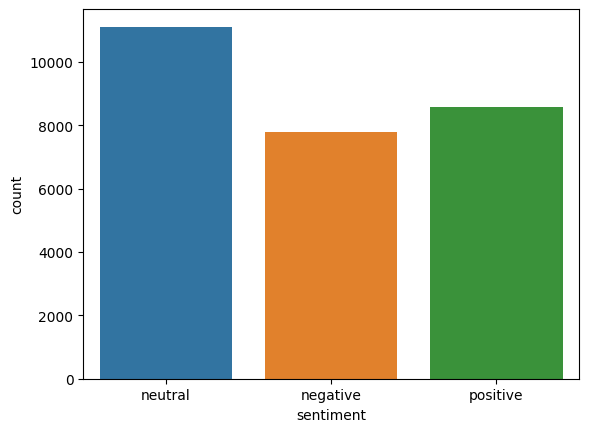

In [10]:
sns.countplot(x='sentiment', data=train_data)

# VADER SENTIMENT ANALYSIS

In [11]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [12]:
sid = SentimentIntensityAnalyzer()

In [13]:
def vader_sentiment_analysis(text):
    score = sid.polarity_scores(text)['compound']
    if (score > 0): sentiment = 'positive'
    elif (score == 0): sentiment = 'negative'
    else: sentiment = 'neutral'
    return (score, sentiment)

In [14]:
test_data['score'] = test_data['text'].apply(sid.polarity_scores)

In [15]:
test_data['compound'] = test_data['score'].apply(lambda d : d['compound'])

In [16]:
test_data['prediction'] = test_data['compound'].apply(lambda x : 'positive' if x>0 else ('neutral' if x==0 else'negative'))

In [17]:
test_data

,textID,text,sentiment,score,compound,prediction
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,"{'neg': 0.0, 'neu': 0.67, 'pos': 0.33, 'compou...",0.7501,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,"{'neg': 0.382, 'neu': 0.618, 'pos': 0.0, 'comp...",-0.7345,negative
3,01082688c6,happy bday!,positive,"{'neg': 0.0, 'neu': 0.2, 'pos': 0.8, 'compound...",0.6114,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,"{'neg': 0.0, 'neu': 0.393, 'pos': 0.607, 'comp...",0.4738,positive
...,...,...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,"{'neg': 0.16, 'neu': 0.84, 'pos': 0.0, 'compou...",-0.2724,negative
3530,416863ce47,All alone in this old house again. Thanks for...,positive,"{'neg': 0.063, 'neu': 0.659, 'pos': 0.279, 'co...",0.7835,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,"{'neg': 0.0, 'neu': 0.728, 'pos': 0.272, 'comp...",0.6696,positive


In [18]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [19]:
print(accuracy_score(test_data['prediction'], test_data['sentiment']))

0.6468590831918506


In [20]:
print(confusion_matrix(test_data['prediction'], test_data['sentiment']))

[[632 221  46]
 [159 678  81]
 [210 531 976]]


In [21]:
print(classification_report(test_data['prediction'], test_data['sentiment']))

              precision    recall  f1-score   support

    negative       0.63      0.70      0.67       899
     neutral       0.47      0.74      0.58       918
    positive       0.88      0.57      0.69      1717

    accuracy                           0.65      3534
   macro avg       0.66      0.67      0.64      3534
weighted avg       0.71      0.65      0.66      3534



# NAIVE BAYES AND SVM

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [23]:
X_train, y_train, X_test, y_test = train_data['text'], train_data['sentiment'], test_data['text'], test_data['sentiment']

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(27480,)
(27480,)
(3534,)
(3534,)


In [25]:
nb_model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                   ('naive_bayes', MultinomialNB())])

svc_model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                    ('svc', LinearSVC())])

In [26]:
nb_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('naive_bayes', MultinomialNB())])

In [27]:
nb_pred = nb_model.predict(X_test)

In [28]:
print(accuracy_score(nb_pred, y_test))

0.6250707413695529


In [29]:
print(confusion_matrix(nb_pred, y_test))

[[ 436  123   28]
 [ 533 1145  447]
 [  32  162  628]]


In [30]:
print(classification_report(nb_pred, y_test))

              precision    recall  f1-score   support

    negative       0.44      0.74      0.55       587
     neutral       0.80      0.54      0.64      2125
    positive       0.57      0.76      0.65       822

    accuracy                           0.63      3534
   macro avg       0.60      0.68      0.62      3534
weighted avg       0.69      0.63      0.63      3534



In [31]:
svc_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('svc', LinearSVC())])

In [32]:
svc_pred = svc_model.predict(X_test)

In [33]:
print(accuracy_score(svc_pred, y_test))

0.6731748726655348


In [34]:
print(confusion_matrix(svc_pred, y_test))

[[647 281  55]
 [314 927 243]
 [ 40 222 805]]


In [35]:
print(classification_report(svc_pred, y_test))

              precision    recall  f1-score   support

    negative       0.65      0.66      0.65       983
     neutral       0.65      0.62      0.64      1484
    positive       0.73      0.75      0.74      1067

    accuracy                           0.67      3534
   macro avg       0.67      0.68      0.68      3534
weighted avg       0.67      0.67      0.67      3534



# GLOVE AND DEEP LEARNING APPROACH

In [36]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from gensim.models import KeyedVectors

In [37]:
def load_glove_embeddings(embedding_file):
    embeddings_index = {}
    with open(embedding_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file = '/kaggle/input/glove-6b-50d/glove.6B.50d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])
num_words = len(tokenizer.word_index)+1

In [39]:
X_train = train_data['text']
y_train = train_data['sentiment']

X_test = test_data['text']
y_test = test_data['sentiment']

In [40]:
X_train_mat = tokenizer.texts_to_sequences(X_train)
X_test_mat = tokenizer.texts_to_sequences(X_test)

In [41]:
max_len = 150

In [42]:
X_train_padded = pad_sequences(X_train_mat, maxlen=max_len)
X_test_padded = pad_sequences(X_test_mat, maxlen=max_len)

In [43]:
label_encoder = LabelEncoder()

y_train_labeled = label_encoder.fit_transform(y_train).reshape((-1,1))
y_test_labeled = label_encoder.transform(y_test).reshape((-1,1))

In [44]:
y_train_enc = to_categorical(y_train_labeled)
y_test_enc = to_categorical(y_test_labeled)

In [45]:
print(X_train_padded.shape)
print(y_train_enc.shape)
print(X_test_padded.shape)
print(y_test_enc.shape)

(27480, 150)
(27480, 3)
(3534, 150)
(3534, 3)


In [46]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding, BatchNormalization
from keras.regularizers import l2

In [47]:
embedding_dim = 50

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [48]:
def create_LSTM_model(num_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=num_words, 
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_len, 
                        trainable=False))
    model.add(LSTM(num_units))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(64, input_dim=64, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dense(3, activation='softmax'))
    
    model.summary()
    return model

In [49]:
num_units = 32
dropout_rate = 0.5

In [50]:
model = create_LSTM_model(num_units, dropout_rate)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           1329950   
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [51]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [53]:
history = model.fit(X_train_padded, y_train_enc, batch_size=128, epochs=40, validation_split=0.2, verbose=2,
                   callbacks=[early_stopping])

Epoch 1/40
172/172 - 14s - loss: 1.3479 - accuracy: 0.4749 - val_loss: 1.1948 - val_accuracy: 0.5144 - 14s/epoch - 80ms/step
Epoch 2/40
172/172 - 11s - loss: 1.0795 - accuracy: 0.5737 - val_loss: 1.0037 - val_accuracy: 0.5888 - 11s/epoch - 63ms/step
Epoch 3/40
172/172 - 11s - loss: 0.9709 - accuracy: 0.6051 - val_loss: 0.9239 - val_accuracy: 0.6188 - 11s/epoch - 62ms/step
Epoch 4/40
172/172 - 11s - loss: 0.9024 - accuracy: 0.6260 - val_loss: 0.8480 - val_accuracy: 0.6443 - 11s/epoch - 62ms/step
Epoch 5/40
172/172 - 11s - loss: 0.8648 - accuracy: 0.6427 - val_loss: 0.8249 - val_accuracy: 0.6561 - 11s/epoch - 61ms/step
Epoch 6/40
172/172 - 10s - loss: 0.8333 - accuracy: 0.6522 - val_loss: 0.7957 - val_accuracy: 0.6699 - 10s/epoch - 61ms/step
Epoch 7/40
172/172 - 11s - loss: 0.8147 - accuracy: 0.6601 - val_loss: 0.7806 - val_accuracy: 0.6694 - 11s/epoch - 63ms/step
Epoch 8/40
172/172 - 10s - loss: 0.7997 - accuracy: 0.6642 - val_loss: 0.7787 - val_accuracy: 0.6670 - 10s/epoch - 61ms/step


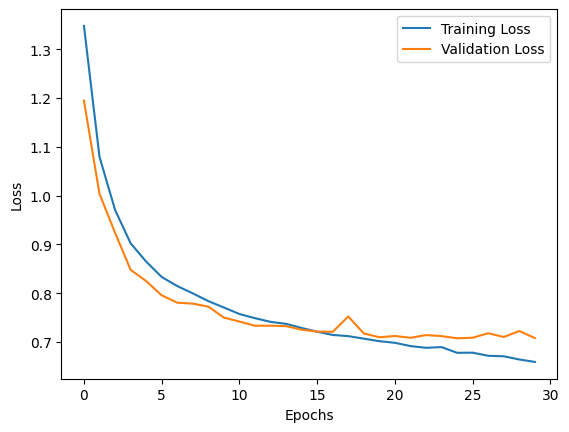

In [54]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
predictions = model.predict(X_test_padded)

111/111 [==============================] - 2s 12ms/step


In [56]:
predictions  = np.array([np.eye(3)[np.argmax(pred)] for pred in predictions])

In [57]:
print(accuracy_score(predictions, y_test_enc))

0.6975099037917374


In [58]:
print(confusion_matrix(predictions.argmax(axis=1), y_test_enc.argmax(axis=1)))

[[ 651  231   48]
 [ 295 1015  256]
 [  55  184  799]]


In [59]:
print(classification_report(predictions, y_test_enc))

              precision    recall  f1-score   support

           0       0.65      0.70      0.67       930
           1       0.71      0.65      0.68      1566
           2       0.72      0.77      0.75      1038

   micro avg       0.70      0.70      0.70      3534
   macro avg       0.69      0.71      0.70      3534
weighted avg       0.70      0.70      0.70      3534
 samples avg       0.70      0.70      0.70      3534

